In [670]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize

## Group Assignment
### Team Number: 16
### Team Member Names: Arya Patel, Saihej Singh, Matthew Gong
### Team Strategy Chosen: RISKY


## General Strategy

***Brief Overview***  *(more detail provided throughout)*

Our group has decided to pursue the "Risky" strategy and create a portfolio with the greatest deviation from the initial value of $750,000 CAD. To achieve this, we will create a portfolio with the maximum possible volatility by considering various "risk" metrics such as Beta and Correlation.
<br>

***Stock Selection***

Our goal is to maximize the return/loss of the final portfolio. Thus, we must minimize the diversification of our portfolio by maximizing the correlation between the stocks. This is because, as learned in Assignment 3, diversification is an effective means to mitigate the risk of a portfolio. The reasoning behind maximizing correlation will be elaborated upon throughout this investigation along with other important metrics. Given these conditions, we will be choosing the minimum amount of stocks (10). This allows us to effectively create a portfolio such that any change in one stock would imply a similar change in another, magnifying the overall portfolio's change. 

# STEP 1: Organize Data
## Organize all ticker info into a DataFrame 
This allows for greater effiency in accessing stock info later on 

In [671]:
print("Loading.", end="")

# Replace 'Tickers_Example.csv' with the actual ticker CSV file
ticker_file = 'Tickers.csv'

# Read the CSV file into a pandas DataFrame with a single column
tickers_df = pd.read_csv(ticker_file, header=None, names=['Tickers'])

# Set the single column as the index
tickers_df.set_index('Tickers', inplace=True)

# Create an info cell for each ticker, saving time when filtering the tickers by volume and country.
info_column = {}
hist_column = {}
long_hist_column = {}
ticker_obj_lst = []

long_start_date = "2018-10-31"
start_date = "2023-01-01"
end_date = "2023-10-31"

tickers_df = tickers_df[~tickers_df.index.duplicated(keep='first')]
# Add info to dict
for ticker in tickers_df.index:
    yf_ticker = yf.Ticker(ticker)
    info_column[ticker] = yf_ticker.fast_info
    hist_column[ticker] = yf_ticker.history(start=start_date, end=end_date)
    long_hist_column[ticker] = yf_ticker.history(start=long_start_date, end=end_date)
    print('.', end='') # So we can tell if the code is running

# Create column for the info]
tickers_df['Info'] = pd.Series(info_column)
tickers_df['History'] = pd.Series(hist_column)
tickers_df['Long History'] = pd.Series(long_hist_column)

# Display DataFrame
print("Complete!")
tickers_df

Loading....

AGN: No timezone found, symbol may be delisted
AGN: No timezone found, symbol may be delisted


.............

CELG: No timezone found, symbol may be delisted
CELG: No timezone found, symbol may be delisted


.....

MON: No timezone found, symbol may be delisted
MON: No timezone found, symbol may be delisted


.......

RTN: No timezone found, symbol may be delisted
RTN: No timezone found, symbol may be delisted


...........Complete!


,Info,History,Long History
Tickers,,,
AAPL,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
ABBV,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
ABT,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open Hig...
ACN,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
AGN,"lazy-loading dict with keys = ['currency', 'da...","Empty DataFrame Columns: [Open, High, Low, Clo...","Empty DataFrame Columns: [Open, High, Low, Clo..."
AIG,"lazy-loading dict with keys = ['currency', 'da...",Open Hig...,Open Hig...
AMZN,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
AXP,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
BA,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...


## Stock Filtering

The first step is to get all available stocks from the "Tickers.csv" file. Then, we look through these tickers to find the qualifying stocks. The stock must follow these specifications:

<ul>
  <li>Only unique tickers are considered. Therefore, all duplicates tickers should not be considered.</li>
  <li>Stocks that have any months with less than 18 trading days should not be considered.</li>
  <li>The stock's average monthly volume should be higher than 150,000 in the time period of January 1, 2023 to October 31, 2023.</li>
  <li>Only consider stocks denominated in either USD or CAD.</li>
</ul>

For every ticker that is considered invalid, our code will output the ticker and the reason for which it is invalid. The valid tickers will be stored in the DataFrame 'tickers_df'. We further separate them into US and Canadian tickers for easier calculations.

In [672]:
# Set the minimum volume threshold for valid stocks
minVolume = 150000

# Define the allowed currencies for stocks
allowed_currencies = ["USD", "CAD"]

# Set the threshold day for the number of trading days in a month
threshold_day = 18

# List to store the number of trading days in each month
days_in_month = []

# Lists to categorize stocks based on currency
CAD_stocks = []
USD_stocks = []
all_stocks = []

for ticker in tickers_df.index:
    
    # Check if the stock's history is empty, indicating it is delisted
    if tickers_df['History'][ticker].empty:
        print(ticker, "is delisted.")
    
    # Group the stock's monthly trading data
    else:
        group_months = tickers_df["History"][ticker].reset_index().groupby(pd.Grouper(key="Date", freq='M'))
        dfs = [group for _, group in group_months]
        
        # Iterate through each month's data and recombine if it has more trading days than the set threshold
        for i, df in enumerate(dfs):
            # Recombine all the months with more trading days than set threshold
            if len(df.index) >= threshold_day:
                days_in_month.append(len(df.index))

        # Check if the stock's currency is not in the allowed currencies (not CAD or USD)
        if tickers_df['Info'][ticker]['currency'] not in allowed_currencies:
            print(ticker, "is not in USD or CAD")
        
        # Check if the stock's volume is below the minimum threshold
        elif tickers_df['History'][ticker]['Volume'].mean() * (np.mean(days_in_month)) < minVolume:
            print(ticker, "only has a volume of", tickers_df.iloc['Info'][ticker]['lastVolume'], "and average days of", np.mean(days_in_month))
        
        # Categorize the stock based on currency and add it to the appropriate list
        else:
            all_stocks.append(ticker)
            if tickers_df['Info'][ticker]['currency'] == 'USD':
                USD_stocks.append(ticker)
            elif tickers_df['Info'][ticker]['currency'] == 'CAD':
                CAD_stocks.append(ticker)

# Display the valid filtered stocks that can be used to determine our risky portfolio.
print("\nValid CAD Stocks:\n",CAD_stocks)
print("\nValid USD Stocks:\n",USD_stocks)
print("\nAll Valid Stocks:\n", all_stocks)

AGN is delisted.
CELG is delisted.
MON is delisted.
RTN is delisted.

Valid CAD Stocks:
 ['RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO']

Valid USD Stocks:
 ['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']

All Valid Stocks:
 ['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


## Get Closing Prices
Makes a Dataframe that shows the USD closing price of each valid stock.
If the stock is denominated in CAD, uses the CADUSD exchange rate to convert it to USD. The reason we are keeping all stocks in the same currency is to increase accuracy of the correlation calculations.

In [673]:
# List to store the standard deviations of each stock's closing prices
stock_stds = []

# DataFrame to store all stocks' closing prices
stocks_df = pd.DataFrame()

# Retreiving CADUSD currency conversion data
exchange = yf.Ticker('CADUSD=x')
exchange_hist = exchange.history(start=start_date, end=end_date)

# Converting the index to datetime and then to date for consistency
exchange_hist.index = pd.to_datetime(exchange_hist.index)
exchange_hist.index = exchange_hist.index.date

# Creating dataframe for all stocks closing prices in CAD
for ticker in all_stocks:
    currCurrency = tickers_df['Info'][ticker]['currency']
    currClose = tickers_df['History'][ticker]['Close']
    
    # Changing stock index to match with CADUSD conversion index
    currClose.index = pd.to_datetime(currClose.index)
    currClose.index = currClose.index.date
    
    # Make sure all stocks are priced in CAD
    if currCurrency == "USD":                                       
        stocks_df[ticker] = currClose * (1/exchange_hist.Close)
    else:
        stocks_df[ticker] = currClose
        
    # Creating a list of stocks with complete data and without any NaN values
    stocks_df = stocks_df.dropna()

# Displaying the closing prices DataFrame
print("\nClosing Prices:")
stocks_df


Closing Prices:


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,PYPL,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
2023-01-03,168.639803,211.621955,145.665504,360.714605,83.711194,116.363344,196.572739,264.929315,44.415907,369.659044,...,101.123030,122.739281,48.790001,25.214359,84.689217,214.563594,695.157322,276.074070,228.572651,57.969782
2023-01-04,171.825503,215.140095,149.087170,362.538272,85.669408,116.421281,202.849784,278.459358,45.635063,370.308280,...,106.234081,123.832161,50.610001,25.520916,85.790459,224.286735,681.944918,280.644092,232.919637,60.282250
2023-01-05,167.653624,211.907267,146.484501,349.085030,84.022259,112.088154,195.258880,276.431070,44.912038,366.241823,...,102.850852,123.467865,48.830002,25.492176,84.384216,218.257935,653.136830,268.617198,225.459261,58.984097
2023-01-06,174.786446,217.070903,149.331011,359.336990,85.871862,116.723626,201.356804,288.825880,45.611842,378.660220,...,103.706123,125.040100,49.560001,25.884954,84.345154,230.288868,656.813348,281.984519,233.373965,60.142445
2023-01-09,173.887157,208.759965,147.720640,362.036668,84.185858,117.369912,199.810620,280.217986,44.509442,369.091829,...,103.558528,125.970016,49.810001,25.827473,84.081490,230.151097,650.852846,278.666550,234.768279,59.975380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,237.100988,200.276445,129.780668,405.302802,81.953050,175.979357,197.689320,249.623493,34.864609,345.100783,...,74.246428,109.029999,71.870003,22.360001,76.830002,199.284689,718.646268,281.216554,202.030681,42.968202
2023-10-25,234.809448,199.610478,128.580154,402.189148,83.768794,166.809285,197.219453,244.229456,35.109788,339.032764,...,70.755502,109.110001,66.900002,22.280001,76.919998,193.072336,728.593420,282.005123,199.568144,42.997469
2023-10-26,230.053533,200.418114,129.719665,403.099924,83.990649,165.041283,197.850774,247.196144,36.053178,332.760333,...,71.430011,110.209999,64.529999,22.320000,77.410004,196.970043,729.290041,279.149871,188.561638,43.851816
2023-10-27,232.073362,191.917889,128.262986,400.661261,82.234739,176.460030,195.205627,248.223765,34.769838,323.965929,...,69.608744,108.470001,64.349998,22.010000,76.160004,195.910134,724.765275,278.656005,184.098169,42.326094


# STEP 2: Analyze Data
<h2>Beta Calculation</h2>

We let the S&P500 denote the market as we are only considering stocks with USD and CAD currencies, thus, having the top 500 USD stocks portray the market is a fair representation. 

Beta is a measure of the expected change of a security or portfolio value in proportion to the market as a whole. Beta is consider to be a better indicator of short-term rather than long-term risk. This is beneficial for our portfolio which would last only 5 trading days. 

Securities with Beta values that are...
- Greater than 1.0: reflect the change of the market to an exaggerated extent
- Less than 1.0 and greater than 0: reflect the change of the market to a lesser extent
- Exactly 1.0: reflect the change in the market exactly 
- Less than 0: reflect an opposite change of the market

The magnitutde of the Beta value reflects the extent to which the security will exaggerate the change in the market. Considering the implications of Beta values, we want to maximize the ***magnitutde*** of our final Portfolio's Beta value. 

The "beta_volatility" function below calcualtes the Beta of each valid stock. Typically, this data would be accessible in yfinance via the info() function, but due to reliability issues with this function, we decided to calculate it ourselves. The code below outputs the list of tickers with their associated Betas in decreasing order.

\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}

In [674]:
# Define a Yahoo Finance Ticker for the S&P 500 index
marketTicker = yf.Ticker("^GSPC")

# Retrieve historical data for the S&P 500 index within the specified date range
marketHist = marketTicker.history(start=long_start_date, end=end_date)

# Dictionary to store beta values for each stock
beta = {}

# Function to calculate beta volatility for a given stock
def beta_volatility(ticker):
    
    # Extract the closing prices for the stock and the market (S&P 500)
    prices = pd.DataFrame(tickers_df["Long History"][ticker]["Close"])
    prices.columns = [ticker]
    prices["Market"] = marketHist['Close']

    # Calculate the monthly percentage change and drop the first row
    monthly_change = prices.resample("M").ffill().pct_change()
    monthly_change = monthly_change.drop(index=monthly_change.index[0])

    # Calculate and return the beta value
    return (monthly_change.cov()/monthly_change["Market"].var()).iat[0, 1]

# Calculate beta values for all stocks and store them in the 'beta' dictionary
for ticker in all_stocks:
    beta[ticker] = abs(beta_volatility(ticker)) # abs() used to achieve magnitude of beta

# Sort the 'beta' dictionary by beta values in descending order
sorted_BTlist = sorted(beta.items(), key=lambda x:x[1], reverse=True)

# Display the sorted list
print("\nA sorted list of each stock's respective Beta values:")
sorted_BTlist


A sorted list of each stock's respective Beta values:


[('SHOP.TO', 1.8105683661552794),
 ('C', 1.5566625787190016),
 ('BA', 1.4762120730903416),
 ('BAC', 1.385100924235344),
 ('PYPL', 1.3792816900669551),
 ('AAPL', 1.3036336027970306),
 ('BLK', 1.2835912984151785),
 ('ACN', 1.2304502282840888),
 ('AXP', 1.2146622102379017),
 ('AMZN', 1.1719942897819302),
 ('UPS', 1.1049472868927004),
 ('UNP', 1.1025188588443435),
 ('BK', 1.095338497762832),
 ('CAT', 1.0879433116414072),
 ('AIG', 1.0351017204530808),
 ('USB', 1.0267303287832696),
 ('TXN', 1.0168277984164418),
 ('PM', 0.7766933616475907),
 ('ABT', 0.6933942475827908),
 ('MO', 0.6535229766860646),
 ('TD.TO', 0.6386755329472696),
 ('UNH', 0.6321137200853707),
 ('PFE', 0.6305325356261329),
 ('LMT', 0.5987247906316039),
 ('KO', 0.5908108425936858),
 ('PEP', 0.5726422162880042),
 ('RY.TO', 0.5664454202725987),
 ('ABBV', 0.5070222129298171),
 ('PG', 0.47479100844737365),
 ('CL', 0.4606666748333337),
 ('T.TO', 0.45967017226480716),
 ('BMY', 0.38539188698367116),
 ('MRK', 0.36452638822546674),
 ('L

In [675]:
# Convert the sorted beta values and stocks list to separate lists
betaList = list(sorted_BTlist)
betaList_vals = []
betaList_stocks = []

# Iterate through the sorted beta values list and separate stocks and beta values
for i in range(len(betaList)):
    betaList_stocks.append(betaList[i][0])
    betaList_vals.append(betaList[i][1])

# Display the list of all stocks ordered from highest to lowest Beta values
print("\nList of all stocks ordered from highest to lowest Beta values:\n")
print(betaList_stocks)


List of all stocks ordered from highest to lowest Beta values:

['SHOP.TO', 'C', 'BA', 'BAC', 'PYPL', 'AAPL', 'BLK', 'ACN', 'AXP', 'AMZN', 'UPS', 'UNP', 'BK', 'CAT', 'AIG', 'USB', 'TXN', 'PM', 'ABT', 'MO', 'TD.TO', 'UNH', 'PFE', 'LMT', 'KO', 'PEP', 'RY.TO', 'ABBV', 'PG', 'CL', 'T.TO', 'BMY', 'MRK', 'LLY', 'BIIB']


<h2>Correlation</h2>

Correlation is the strength of a relationship between two securities, or to what extent the two variables move in coordination with one another. If the two variables move in the same direction, then those variables are said to have a positive correlation. If they move in opposite directions, then they have a negative correlation. The extent to which they move in the same/opposite direction is reflected by the magnitude of the correlation. We are using correlation values to increase our portfolio's risk and volatility, by chosing stocks that are the most positively correlated to eachother so any change would be magnified.


The code block below outputs a correlation matrix of all the valid stocks. It also create a dictionary that has all possible stock pairs as keys, and their correlation as values (for easy access of values later) - ordered from highest correlated stocks to lowest. 

In [676]:
# Calculate the correlation matrix for the stocks' closing prices
stocks_corr = stocks_df.corr()

# Create a dictionary of stock pairs and their correlation coefficients
correlation_dict = {}
for i in range(len(stocks_corr.columns)):
    for j in range(i + 1, len(stocks_corr.columns)):
        stock_pair = (stocks_corr.columns[i], stocks_corr.columns[j])
        correlation_coefficient = stocks_corr.iloc[i, j]
        correlation_dict[stock_pair] = correlation_coefficient

# Sort the dictionary based on correlation coefficients in descending order
sorted_corrPairsDict = dict(sorted(correlation_dict.items(), key=lambda item: item[1], reverse=True))

# Display the dictionary with correlations ordered from highest to lowest
sorted_corrPairsDict

# Display the original correlation matrix
print('\nCorrelation Matrix:')
stocks_corr


Correlation Matrix:


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,PYPL,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
AAPL,1.000000,-0.412003,-0.236540,0.765406,-0.098706,0.859363,0.028720,0.146018,-0.660112,-0.143137,...,-0.667723,-0.500902,0.871692,-0.589936,-0.414228,-0.166168,0.126990,0.347555,-0.301694,-0.693244
ABBV,-0.412003,1.000000,-0.159572,-0.308239,-0.044701,-0.326484,-0.296632,-0.063601,0.054739,-0.272347,...,0.155823,0.064396,-0.619952,0.070569,0.029613,-0.096470,0.430204,0.099806,0.146268,0.182809
ABT,-0.236540,-0.159572,1.000000,-0.240977,-0.033423,-0.280659,0.034817,0.385251,0.465346,0.494454,...,0.507111,0.617423,0.014768,0.495271,0.478486,0.315726,-0.400822,0.026774,0.391726,0.281650
ACN,0.765406,-0.308239,-0.240977,1.000000,0.393938,0.917357,-0.051854,0.226013,-0.362580,-0.361674,...,-0.685093,-0.598875,0.706022,-0.791494,-0.143366,-0.253021,0.258312,0.623629,-0.511331,-0.337330
AIG,-0.098706,-0.044701,-0.033423,0.393938,1.000000,0.279757,-0.080478,-0.017821,0.406785,-0.484972,...,-0.218681,-0.205083,-0.022311,-0.530876,0.540119,-0.435777,0.336219,0.578206,-0.522299,0.486618
AMZN,0.859363,-0.326484,-0.280659,0.917357,0.279757,1.000000,-0.108879,0.167480,-0.519679,-0.372002,...,-0.789094,-0.651628,0.786403,-0.813472,-0.254313,-0.363119,0.258587,0.597491,-0.562093,-0.493526
AXP,0.028720,-0.296632,0.034817,-0.051854,-0.080478,-0.108879,1.000000,0.423365,0.472461,0.023059,...,0.429859,0.548250,0.095058,0.204307,0.395757,0.604372,-0.494091,-0.063453,0.552565,0.411628
BA,0.146018,-0.063601,0.385251,0.226013,-0.017821,0.167480,0.423365,1.000000,0.331519,0.017283,...,0.194877,0.380515,0.208805,-0.026178,0.343799,0.513982,-0.351619,0.490339,0.457462,0.280385
BAC,-0.660112,0.054739,0.465346,-0.362580,0.406785,-0.519679,0.472461,0.331519,1.000000,0.030572,...,0.703095,0.727113,-0.442652,0.367238,0.873504,0.390425,-0.290293,0.084127,0.427205,0.947259
BIIB,-0.143137,-0.272347,0.494454,-0.361674,-0.484972,-0.372002,0.023059,0.017283,0.030572,1.000000,...,0.283233,0.387730,0.050838,0.702429,-0.078764,0.230525,-0.347801,-0.553590,0.287933,-0.192044


## Sorted list of all possible correlation pairs:

In [677]:
print("\nSorted Dictionary of All Possible Correlation Pairs:")
sorted_corrPairsDict


Sorted Dictionary of All Possible Correlation Pairs:


{('BK', 'USB'): 0.9497088319317271,
 ('BAC', 'USB'): 0.9472594069541623,
 ('ACN', 'AMZN'): 0.917356953937512,
 ('BMY', 'PFE'): 0.9091023147804158,
 ('BMY', 'T.TO'): 0.897112884701913,
 ('AMZN', 'LLY'): 0.8906843572055438,
 ('BAC', 'BK'): 0.8850727033873506,
 ('C', 'RY.TO'): 0.8832896192755634,
 ('BAC', 'TD.TO'): 0.8735037919035785,
 ('AAPL', 'SHOP.TO'): 0.8716919785156565,
 ('AAPL', 'AMZN'): 0.8593625075032972,
 ('TXN', 'UPS'): 0.8586654836800945,
 ('PYPL', 'RY.TO'): 0.8567695791154116,
 ('BMY', 'PYPL'): 0.8500688775037587,
 ('TD.TO', 'USB'): 0.8413447047214136,
 ('ACN', 'LLY'): 0.8226562135375395,
 ('CAT', 'UNP'): 0.8226189101517537,
 ('PFE', 'PYPL'): 0.8131924710948322,
 ('C', 'PYPL'): 0.8057026410220145,
 ('KO', 'PEP'): 0.7985860378333453,
 ('BMY', 'C'): 0.7970325422875694,
 ('BMY', 'RY.TO'): 0.7931771991687805,
 ('PYPL', 'UPS'): 0.7864928016617351,
 ('AMZN', 'SHOP.TO'): 0.7864033465013135,
 ('RY.TO', 'UPS'): 0.7777792483142367,
 ('BK', 'TD.TO'): 0.7729276513080774,
 ('PYPL', 'T.TO'

## The Importance of High Correlation: Case Analysis

Correlation of Portfolio A: -0.22057860851967495
Correlation of Portfolio A: 0.8473752457669405


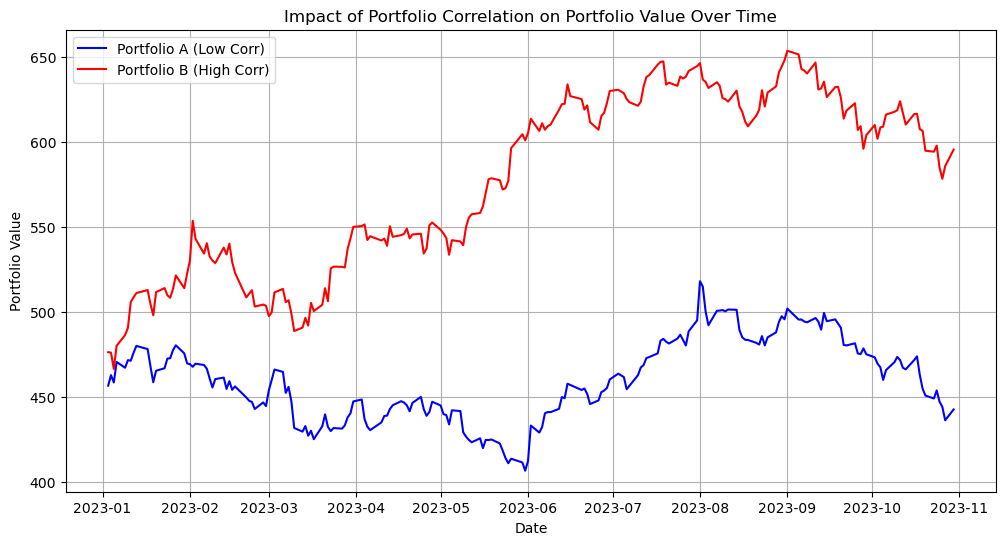

In [678]:
portfolio_A = ["PYPL", "CAT", "PG"]       # Low Correlation
portfolio_B = ["AAPL", "AMZN", "ACN"]   # High Correlation

##average correlation values calculated manually
print("Correlation of Portfolio A:", -0.22057860851967495)
print("Correlation of Portfolio A:", 0.8473752457669405)

##Getting Closing values of each stock
pypl_close = yf.Ticker('PYPL').history(start=start_date, end=end_date).Close
cat_close = yf.Ticker('CAT').history(start=start_date, end=end_date).Close
pg_close = yf.Ticker('PG').history(start=start_date, end=end_date).Close
aapl_close = yf.Ticker('AAPL').history(start=start_date, end=end_date).Close
amzn_close = yf.Ticker('AMZN').history(start=start_date, end=end_date).Close
acn_close = yf.Ticker('ACN').history(start=start_date, end=end_date).Close

data = pd.DataFrame({
    "Portfolio A (Low Corr)": (pypl_close + cat_close + pg_close).dropna(),
    "Portfolio B (High Corr)": (aapl_close + amzn_close + acn_close).dropna()
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Portfolio A (Low Corr)'], label='Portfolio A (Low Corr)', color='blue')
plt.plot(data['Portfolio B (High Corr)'], label='Portfolio B (High Corr)', color='red')

# Adding details
plt.title('Impact of Portfolio Correlation on Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### Analysis
Analyzing the graph above we see that the **high correlation** portfolio's value **rises significantly more** than the low correlation portfolio. This is because in a high correlation portfolio, assets magnify any market trends as they move together in the same direction. When the market is bullish this leads to larger gains. Conversely, a low correlation portfolio, with assets moving independently often has its assest counteracting one anothers gains. This can be seen in our graph above as the low correlation portfolio results in a very slight decrease in value over time. For our goal of identifying the most risky portfolio, we will need to give **importance to high correlation as it amplifies the risk and portfit/loss.**

# Determining the Riskiest Portfolio

## Algorithm Outline
#### 1. For every valid stock, find 9 other stocks that are most strongly correlated to it (form the portfolios)
#### 2. Get the average correlation between all stocks of each portfolio
#### 3. Find the optimal weightings for each stock in each portfolio
#### 4. Find the Beta of each portfolio
#### 5. Get the riskiness index of each portfolio
#### 6. Compare and determine the riskiest portfolio

### **Explanation**:
Our method incoorporates both correlation and beta values. When looking at the risk factor of a portfolio, the more correlated stocks are to each other, the higher the risk. This is because with a high correlation, any change in one stock would imply a similar change in the others, thus intensifying the overall portfolio's change. Thus, as a first step, we make 'n' portfolios, where 'n' is the amount of valid stocks given. This reduces the amount of portfolios we need to analyze, in comparison to looking at every possible combination of 10 stocks - thus reducing computational burden and increasing the effiency of our method.

We identify 9 valid stocks with the highest correlation to every valid stock. By extension, all 10 stocks are most correlated to each other. This creates a list of 'n' portfolios that are riskier than other possible portfolios in regards to the correlation factor. 

Alongside making these portfolios, we calculate the **average correlation between all stocks** for each portfolio, allowing for greater accuracy of average portfolio correlation.

In [679]:
allPorts = []
allPortCorrAvgs = []

# Making the list of portfolios##
for stock in betaList_stocks:
    
    tempPort = [stock]

    # For each possible correlation given all the stocks
    # Correlations are sorted from highest to lowest
    for item in sorted_corrPairsDict:   

        if (item[0]==stock):
            tempPort.append(item[1])

        elif(item[1]==stock):
            tempPort.append(item[0])
                      
        if (len(tempPort) == 10):
            allPorts.append(tempPort)
            break;
            
# Remove duplicate portfolios (for aesthetic purposes, doesn't really matter for calculations)
unique_ports = []

for port in allPorts:
    # Convert the inner list to a set to ignore the order
    portfolio_set = set(port)
    
    # Check if the set representation of the portfolio is not already in the unique_portfolios list
    if portfolio_set not in (set(p) for p in unique_ports):
        unique_ports.append(port)

# Get average correlation between all stocks for every portfolio##
def average_portfolio_correlation(portfolio, correlations):
    # Check if the portfolio has at least two stocks
    if len(portfolio) < 2:
        return "The portfolio needs at least two stocks to calculate correlation."

    total_correlation = 0
    count = 0

    # Iterate over all unique pairs of stocks
    for i in range(len(portfolio)):
        for j in range(i + 1, len(portfolio)):
            pair = (portfolio[i], portfolio[j])

            # Check both combinations as the dictionary keys could be in any order
            if pair in correlations:
                total_correlation += correlations[pair]
                count += 1
            elif (pair[1], pair[0]) in correlations:
                total_correlation += correlations[(pair[1], pair[0])]
                count += 1

    # Check if any correlations were found
    if count == 0:
        return "No correlations found for the provided portfolio."

    # Calculate the average correlation
    average_correlation = total_correlation / count
    return average_correlation

allPortCorrAvgs = []

for portfolio in unique_ports:
    allPortCorrAvgs.append(average_portfolio_correlation(portfolio, sorted_corrPairsDict))
    

print("Unique Portfolios: \n", unique_ports, "\n")
print("All Correlation Averages: \n", allPortCorrAvgs)


Unique Portfolios: 
 [['SHOP.TO', 'AAPL', 'AMZN', 'ACN', 'LLY', 'PEP', 'PG', 'UNP', 'CAT', 'BA'], ['C', 'RY.TO', 'PYPL', 'BMY', 'T.TO', 'BAC', 'PFE', 'UPS', 'BK', 'USB'], ['BA', 'TXN', 'BLK', 'UNP', 'UPS', 'AXP', 'ABT', 'KO', 'RY.TO', 'PEP'], ['BAC', 'USB', 'BK', 'TD.TO', 'BLK', 'C', 'RY.TO', 'PYPL', 'PFE', 'PM'], ['PYPL', 'RY.TO', 'BMY', 'PFE', 'C', 'UPS', 'T.TO', 'BAC', 'TXN', 'PM'], ['BLK', 'BAC', 'TD.TO', 'USB', 'BK', 'ABT', 'PM', 'PYPL', 'RY.TO', 'BA'], ['ACN', 'AMZN', 'LLY', 'AAPL', 'SHOP.TO', 'CAT', 'UNP', 'PG', 'AIG', 'UNH'], ['AXP', 'TXN', 'C', 'UPS', 'RY.TO', 'BK', 'BAC', 'PYPL', 'BA', 'USB'], ['UPS', 'TXN', 'PYPL', 'RY.TO', 'BMY', 'C', 'LMT', 'T.TO', 'KO', 'PFE'], ['UNP', 'CAT', 'ACN', 'AMZN', 'LLY', 'AIG', 'BA', 'PG', 'AAPL', 'UNH'], ['CAT', 'UNP', 'AIG', 'ACN', 'LLY', 'AMZN', 'BLK', 'TD.TO', 'UNH', 'BA'], ['AIG', 'CAT', 'UNP', 'TD.TO', 'USB', 'BLK', 'BK', 'LLY', 'BAC', 'ACN'], ['TXN', 'UPS', 'PYPL', 'RY.TO', 'AXP', 'C', 'BMY', 'PFE', 'BA', 'T.TO'], ['ABT', 'RY.TO', 'KO', '

## Portfolio Beta Calculation
<br>
Earlier, we found the Beta of each individual stock. Now, to calculate the beta of a portfolio, we use the weighted average of the betas of the individual stocks in the portfolio. The formula for this calculation is as follows:

$$
\text{Portfolio Beta} = \sum_{i=1}^{n} (w_i \times \beta_i)
$$

Where:
- $\sum \text{represents the sum over all stocks in the portfolio.} $
- $ {w_i} \text{ is the weight of the } {i^{th}} \text{ stock in the portfolio.} $
- $ {\beta_i} \text{ is the beta of the } {i^{th}} \text{ stock.} $

Thus, we must first find the weightings of each stock in each of the portfolios that would maximize the overall portfolio returns/losses (maximize the risk of each portfolio). 

## Weightage Optimization Algorithm

***Algorithm Used:***
- The method specified we use in our algorithm is 'SLSQP', which stands for Sequential Least Squares Programming. This is an advanced mathematical technique used for optimization problems, especially those with constraints (like ours which has a maximum and minimum weight limit for each stock in the portfolio).

***Efficiency:***
- Rather than brute-forcing every possible combination of weights (which we understand to be incredibly time-consuming and computationally expensive, especially with a large number of stocks in the CSV), SLSQP uses mathematical methods to navigate towards the optimal solution. In laymen terms our algorithm makes educated guesses about which direction to move in the "solution space" (the range of all possible risky portfolio weightages) to find the best solution (the most risky stock weightage).

***How It Works:***
- *Starting Point:*
    - Our algorithm begins with an initial_weight_guess and evaluates how good that guess is (how risky the portfolio is with those weights).
- *Iterative Improvement:*
    - Based on this evaluation, the algorithm makes adjustments to the weights and checks if these new weights make the portfolio riskier. As the impact of each stock on the portfolio's risk is proportional to its weight: heavier-weighted stocks have a more significant influence. This makes **standard deviation** an invaluable tool for assessing and optimizing the risk level of a portfolio. As it quantifies the volatility of a portfolio, meaning a higher standard deviation indicates a wider range of potential returns and, hence, higher risk. On the other hand, a lower standard deviation suggests more stable returns and lower risk. This is why we implement standard deviation calculations to make strategic adjustments in stock weightings to align with our specific risk preference (as risky as possible!). We then continue the iterative process, making further adjustments and evaluations for every portfolio.
- *Considering Constraints:*
    - Throughout this process, we always ensure that the constraints on stock weight such as the total weight being 100%, and each stock's weight within our set minimum and maximum are always met.
- *Finding the Optimum:*
    - The algorithm stops its iterative process once it reaches a point where making further changes doesn't improve the riskiness of the portfolio by even relatively small margins.

***Outcome:***
- *Result:*
    - The end result is a set of weights for each stock in our portfolio that are optimized for maximum risk, within the bounds of our weightage constraints.

In simple terms, think of our algorithm as a very smart system that tries out different combinations of how much money to put in each stock, but it does so in a clever way that doesn't require checking every single possibility. It keeps tweaking the amounts until it finds a combination that makes your portfolio as risky as we can, without breaking any of the set rules.

In [680]:
# Define the maximum and minimum weight each stock can have in the portfolio
max_stock_weight = 0.20  # Maximum weight (20%)
min_stock_weight = 0.05  # Minimum weight (5%)

def optimized_weightage(portfolio):
    
    all_returns = (stocks_df.pct_change() * 100).dropna()
    filtered_returns = all_returns[portfolio]
    filtered_returns
    
    # Function to calculate the risk (volatility) of the portfolio
    def calculate_portfolio_volatility(stock_weights, stock_returns):
        """
        Calculate the volatility of a portfolio based on stock weights and returns.
        
        :param stock_weights: A list of weights representing the fraction of the total portfolio value
                              held in each stock.
        :param stock_returns: A DataFrame containing the historical returns of each stock.
        :return: The volatility (standard deviation) of the portfolio's returns.
        """
        # Calculate expected portfolio return as a weighted average of individual stock returns
        expected_portfolio_return = np.dot(stock_weights, stock_returns.mean())
        
        # Calculate portfolio volatility as the square root of the weighted sum of covariances
        portfolio_variance = np.dot(stock_weights.T, np.dot(stock_returns.cov(), stock_weights))
        portfolio_volatility = np.sqrt(portfolio_variance)
        
        return portfolio_volatility

    # Function to be minimized by the optimizer
    def objective_function(stock_weights, stock_returns):
        """
        The objective function to be minimized by the optimizer. It returns the negative of the
        portfolio volatility, as the goal is to maximize volatility.
    
        :param stock_weights: A list of weights for each stock in the portfolio.
        :param stock_returns: A DataFrame of historical returns for each stock.
        :return: Negative of the portfolio's volatility.
        """
        return -calculate_portfolio_volatility(stock_weights, stock_returns)
    
    # Set constraints and bounds for the optimization
    total_weight_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Sum of weights must be 1
    weight_bounds = [(min_stock_weight, max_stock_weight) for _ in range(len(filtered_returns.columns))]  # Bounds for each stock (between 5% to 20%)
    
    # Initial guess for the stock weights (evenly distributed)
    initial_weight_guess = [1 / len(filtered_returns.columns)] * len(filtered_returns.columns)
    
    # Perform the optimization to find the best stock weights
    optimized_portfolio = minimize(objective_function, initial_weight_guess, args=(filtered_returns,), method='SLSQP', bounds=weight_bounds, constraints=total_weight_constraint)
    
    # Extract the optimized weights for each stock
    optimized_stock_weights = optimized_portfolio.x
    
    return optimized_stock_weights

portfolio_betas = []

# Determine the optimized stock weightage to ensure max risk in each portfolio and append to the list
for portfolio in unique_ports:
    portfolio_betas.append(optimized_weightage(portfolio))
    
print("\nList of optimized risk weightings for every portfolio:")
portfolio_betas


List of optimized risk weightings for every portfolio:


[array([0.2 , 0.05, 0.2 , 0.1 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.2 ]),
 array([0.1 , 0.05, 0.05, 0.05, 0.05, 0.2 , 0.05, 0.05, 0.2 , 0.2 ]),
 array([0.2 , 0.05, 0.05, 0.2 , 0.1 , 0.2 , 0.05, 0.05, 0.05, 0.05]),
 array([0.2 , 0.2 , 0.2 , 0.05, 0.05, 0.1 , 0.05, 0.05, 0.05, 0.05]),
 array([0.2 , 0.05, 0.05, 0.05, 0.2 , 0.1 , 0.05, 0.2 , 0.05, 0.05]),
 array([0.05, 0.2 , 0.05, 0.2 , 0.1 , 0.05, 0.05, 0.2 , 0.05, 0.05]),
 array([0.1 , 0.2 , 0.05, 0.05, 0.2 , 0.2 , 0.05, 0.05, 0.05, 0.05]),
 array([0.05, 0.05, 0.1 , 0.05, 0.05, 0.2 , 0.2 , 0.05, 0.05, 0.2 ]),
 array([0.2 , 0.1 , 0.2 , 0.05, 0.05, 0.2 , 0.05, 0.05, 0.05, 0.05]),
 array([0.05, 0.2 , 0.1 , 0.05, 0.05, 0.2 , 0.2 , 0.05, 0.05, 0.05]),
 array([0.2 , 0.05, 0.2 , 0.1 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.2 ]),
 array([0.2 , 0.05, 0.05, 0.05, 0.2 , 0.05, 0.1 , 0.05, 0.2 , 0.05]),
 array([0.05, 0.1 , 0.2 , 0.05, 0.2 , 0.2 , 0.05, 0.05, 0.05, 0.05]),
 array([0.05, 0.05, 0.05, 0.05, 0.2 , 0.05, 0.2 , 0.2 , 0.05, 0.1 ]),
 array([0.1 , 0.05, 

## Calculating the Portfolio Betas

After determining the optimal weightings of each stock in each portfolio to ensure the most possible risk, we can calculate the Beta of each portfolio as described earlier. 

To determine the riskiest portfolio we would need a unit of measure to compare amoungst all the portfolios to isolate the most risky portfolio. Thus, we constructed a riskiness index for portfolio assessment. First, we normalize the beta values to a scale between 0 and 1. By the definition of Beta, it theoretically has no limit. Thus, by normalizing the Beta values, we ensure that they are directly comparable to correlation coefficients. Normalizing compares relative values, which is optimal for our purposes. This normalization facilitates a more coherent and unified analysis in our algorithm, enabling the integration of both volatility (beta) and stock interdependence (correlation) into a singular riskiness index.

The concept of our riskiness index which is made by summing the two metrics, aligns with the modern portfolio theory (MPT), which emphasizes the importance of understanding both the individual risk of assets (reflected in beta) and the interaction among them (reflected in correlation) for holistic risk assessment [(Markowitz, 1952)](https://en.wikipedia.org/wiki/Modern_portfolio_theory). By scaling beta to match the correlation range, we avoid the potential distortion that could arise from combining variables of differing scales. Using this normalized riskiness index, the portfolio with the highest cumulative value represents the highest potential for volatility and correlated movement, therefore the most risky. This method, grounded in fundamental financial principles, offers a comprehensive and balanced tool for our portfolio risk analysis.

In [681]:
# Convert the sorted beta values list to a dictionary
sorted_BTdict = {key: value for key, value in sorted_BTlist}

# Lists to store average beta values for each portfolio
avg_portfolio_betas = []
portfolio_counter = 0
    
# Iterate through each portfolio in the list of all portfolios
for portfolio in unique_ports:
    ticker_counter = 0
    portfolio_beta_sum = 0
    
    # Iterate through each stock ticker in the current portfolio
    for ticker in portfolio:
        # Retrieve the beta value for the current stock from the sorted dictionary
        ticker_beta = sorted_BTdict[ticker]
        
        # Calculate the beta value for the current stock in the portfolio
        beta_value = ticker_beta * portfolio_betas[portfolio_counter][ticker_counter]
        portfolio_beta_sum += beta_value
        ticker_counter += 1
    
    # Calculate and store the average beta value for the current portfolio
    avg_portfolio_betas.append(portfolio_beta_sum)
    portfolio_counter += 1

# Display the Beta value of each portfolio
print("\nThe Beta value of each portfolio:\n")
print(avg_portfolio_betas)


The Beta value of each portfolio:

[1.2580722146418757, 1.0834136576334488, 1.1053589483022068, 1.1208611999769842, 1.1664818260540928, 1.1395070350911745, 1.180749957982596, 1.1950190319770586, 1.071439873395973, 1.0933448153167769, 1.100536924976263, 1.082275202084344, 1.1673700188267393, 1.0116983636653982, 0.9627715266219261, 1.10898793857405, 0.9992526534660209, 0.5493811394321497, 0.8679723998995357, 1.1595809346190757, 0.8022484142849132, 1.1452373280140749, 0.40023390657370317, 0.9797293815529828, 1.1117281515817845, 0.6168711319364311]


## The Importance of a High Beta Value: Case Analysis

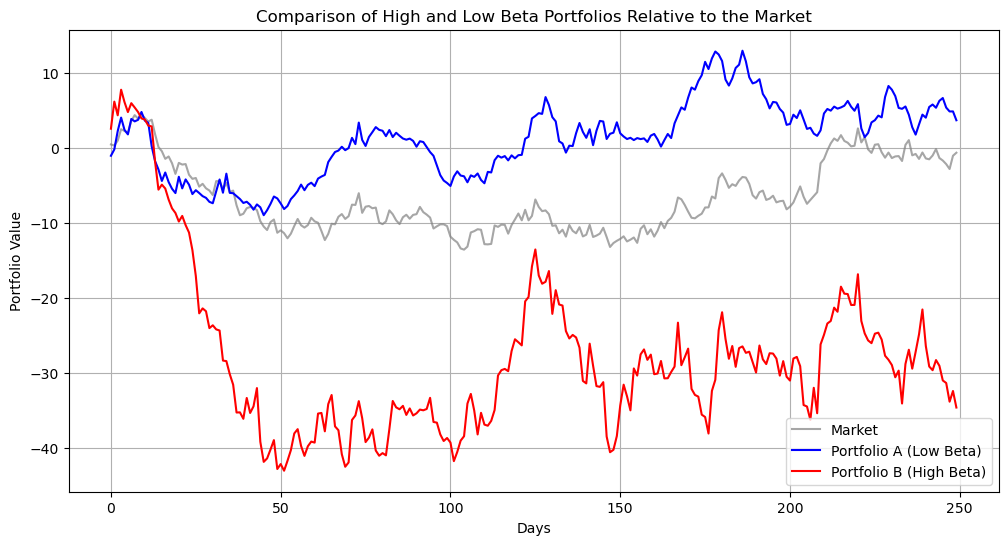

In [682]:
# Setting seed for reproducibility
np.random.seed(42)

# Simulating market movements
days = 250  # Roughly the number of trading days in a year
market_trend = np.random.normal(0, 1, days).cumsum()

# Simulating two portfolios: A (low beta) and B (high beta)
low_beta = 0.5
high_beta = 1.5

portfolio_A = low_beta * market_trend + np.random.normal(0, 1, days).cumsum()
portfolio_B = high_beta * market_trend + np.random.normal(0, 2, days).cumsum()

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Market': market_trend,
    'Portfolio A (Low Beta)': portfolio_A,
    'Portfolio B (High Beta)': portfolio_B
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Market'], label='Market', color='grey', alpha=0.7)
plt.plot(data['Portfolio A (Low Beta)'], label='Portfolio A (Low Beta)', color='blue')
plt.plot(data['Portfolio B (High Beta)'], label='Portfolio B (High Beta)', color='red')

# Adding details
plt.title('Comparison of High and Low Beta Portfolios Relative to the Market')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### Analysis

The plot above showcases the behaviours of portfolios with high and low beta values relative to market movements. We can see that the **low beta** stock **moves conservatively**. In contrast, the **high beta** stock experiences more **dramatic shifts**, notably incurring a considerable loss in this instance. This plot makes evident why ensuring the highest beta is crucial for a risky portfolio, as it allows for the potential of both **substantial gains and significant losses.**

***Extra:*** <u>Unused Statstic</u>

The Sharpe ratio compares the return of an investment with its risk as we understood through assingment 3. It is a widely used calculation to measure the returns of a risky asset in comparsion to a risk-free assset. It compares a fund's historical or projected returns relative to an investment benchmark, with the historical or expected variability of such returns. Thus, the sharpe ratio of a portfolio would provide us with a value that indicates what would be an acceptable amount of risk for a stock's return. We understand the importance Sharpe ratio provides for determining a safe portfolio, but in a risky portfolio, our returns are less relevant than overall risk. Thus, the Sharpe ratio is not used in our calculations.

## Riskiness Results

Finally, we choose the portfolio with the highest "risk factor" (sum of Beta and correlation), as the riskiest portfolio. Below is a DataFrame that shows the sum, Beta, and correlation of every portfolio. *The row highlighted in Green represents the riskest portfolio, or the one with the highest sum.*

In [683]:
# Initilize variables to be used in the code below
compare = pd.DataFrame()   
beta_corr_sum = []

# Normalize the beta pairs between 0 and 1 and store them in the following list
normalized_PortBetaList = []

maxBeta = max(avg_portfolio_betas)
minBeta = min(avg_portfolio_betas)

# Normalize the beta values of each portfolio to be betweek 0 and 1
# Important step! Ensures that the beta values are on the same scale as the correlation values
if maxBeta != minBeta:
    for beta in avg_portfolio_betas:
        normalized_PortBetaList.append(round((beta - minBeta)/(maxBeta - minBeta), 6))
else:
    # If the length of the list of Betas is 1, simply take that Beta value as 1 (since it is the max and min)
    normalized_PortBetaList.append(1)

# Determine the riskiness level of each portfolio
for index in range(len(unique_ports)):
    beta_corr_sum.append(normalized_PortBetaList[index] + allPortCorrAvgs[index])

# Creating the three columns in our DataFrame to store the data used to determine the riskiest portoflio
compare['Riskiness'] = beta_corr_sum
compare['Portfolio Beta'] = normalized_PortBetaList
compare['Portfolio Correlation'] = allPortCorrAvgs

riskiest_sum = max(beta_corr_sum)
riskiest_portfolio_index = beta_corr_sum.index(riskiest_sum)
riskiestPortfolio = allPorts[riskiest_portfolio_index]

# Function to apply the row highlight
def highlight_row(row):
    if row.name == riskiest_portfolio_index:
        return ['background-color: #90EE90']*len(row)
    else:
        return ['']*len(row)

# Apply the style
styled_compare = compare.style.apply(highlight_row, axis=1)

# Display the DataFrame
styled_compare

,Riskiness,Portfolio Beta,Portfolio Correlation
0,1.432745,1.000000,0.432745
1,1.469476,0.796397,0.673079
2,1.150687,0.821979,0.328708
3,1.505388,0.840050,0.665338
4,1.545883,0.893231,0.652652
5,1.434638,0.861786,0.572852
6,1.381656,0.909864,0.471792
7,1.493687,0.926498,0.567189
8,1.424345,0.782439,0.641906
9,1.221375,0.807974,0.413401


# Final Results:

In [684]:
print("\nThe riskiest possible portfolio is:", riskiestPortfolio)


The riskiest possible portfolio is: ['PYPL', 'RY.TO', 'BMY', 'PFE', 'C', 'UPS', 'T.TO', 'BAC', 'TXN', 'PM']


Through our algorithm, we crafted the most risky portfolio by carefully using the optimal selection of financial metrics. Leveraging beta, we gauged each portfolio's sensitivity to market fluctuations, isolating those with the highest results. Correlation analysis provided insight into how individual assets move cohesively, amplifying overall portfolio risk through interdependence. Additionally, we fine-tuned stock weightings to maximize volatility through the use of standard deviation calculations.

Our calculated approach based upon the Modern Portfolio Theory ensures that we are presenting a portfolio with the highest amount of risk.

~*Or you gave us 10 stocks and it was the only possible portfolio to make lol*~

## Creating Final DataFrame

In [685]:
Portfolio_Final = pd.DataFrame()
Portfolio_Final['Ticker'] = riskiestPortfolio
Portfolio_Final.index += 1
Portfolio_Final

,Ticker
1,PYPL
2,RY.TO
3,BMY
4,PFE
5,C
6,UPS
7,T.TO
8,BAC
9,TXN
10,PM


In [686]:
# Initialize a dictionary to hold each stock's respective price
closing_price = []

# Fetch the closing price for each stock and store it in the list
for ticker in riskiestPortfolio:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1d")  # Fetches the latest available day's data
    closing_price.append(hist['Close'].iloc[-1]) # Get the last closing price

# As the code is to be run on November 25, 2023 the last closing price will be the closing price of November 25, 2023. 

Portfolio_Final['Price'] = closing_price
Portfolio_Final

,Ticker,Price
1,PYPL,55.759998
2,RY.TO,118.959999
3,BMY,49.759998
4,PFE,30.500000
5,C,45.230000
6,UPS,152.029999
7,T.TO,24.059999
8,BAC,29.730000
9,TXN,153.589996
10,PM,94.339996


In [687]:
# Initialize a dictionary to hold each stock's respective currency denomination
currencies = []

# Fetch the currency for each stock and store it in the list
for ticker in riskiestPortfolio:
    currencies.append(tickers_df['Info'][ticker]['currency'])

Portfolio_Final['Currency'] = currencies
Portfolio_Final

,Ticker,Price,Currency
1,PYPL,55.759998,USD
2,RY.TO,118.959999,CAD
3,BMY,49.759998,USD
4,PFE,30.500000,USD
5,C,45.230000,USD
6,UPS,152.029999,USD
7,T.TO,24.059999,CAD
8,BAC,29.730000,USD
9,TXN,153.589996,USD
10,PM,94.339996,USD


In [688]:
# Calculate fees of $4.95 per stock
num_stocks = len(riskiestPortfolio)
fees = (4.95 * num_stocks)

# Calculate the investment amount split between the stocks in the portfolio after fees
starting_capital = 750000
investment_amount = starting_capital - fees

riskiest_portfolio_weightage = optimized_weightage(riskiestPortfolio)

start_values = [investment_amount] * num_stocks

# Calculate the respective value to be invested in each stock
respective_value = [a * b for a, b in zip(riskiest_portfolio_weightage, start_values)]

# Initialize an empty list to store the number of shares for each stock
shares = []

# Iterate through each stock's value to calculate the number of shares we must buy
for index in range (len(respective_value)):
    num_shares = respective_value[index] / closing_price[index]
    shares.append(num_shares)

# Update the Portfolio_Final DataFrame with shares, value, and weight of each stock
Portfolio_Final['Shares'] = shares
Portfolio_Final['Value'] = respective_value
Portfolio_Final['Weight'] = riskiest_portfolio_weightage

In [689]:
total_portfolio_value = sum(Portfolio_Final['Value'])
total_amount_invested = total_portfolio_value + fees

total_portfolio_weightage = sum(Portfolio_Final['Weight']) * 100

# Showing that our total adds to $750,000 CAD and that the weights add to 100%.
print("The total amount of capital invested adds up to: $" + str(round(total_amount_invested, 2)))
print("The total weight of the portfolio adds up to be: " + str(round(total_portfolio_weightage, 2)) + "%.")

The total amount of capital invested adds up to: $750000.0
The total weight of the portfolio adds up to be: 100.0%.


***Note:***
- The value we compute for the total amount invested in reality comes out to be \\$750000.0000000001 and the total weight of the portfolio comes out to be 100.00000000000003\%. This is because when you add two floating-point numbers in Python, you can often notice that the result is not as accurate as expected. This is due to the way floating-point numbers are represented in computer systems, computers represent floating-point numbers in binary, not decimal. This means they have to convert a decimal number to its closest binary equivalent. However, not all decimal fractions can be represented exactly in binary. For example, 0.1 in decimal cannot be precisely represented in binary. This leads to small rounding errors, just like in our case. Also if the values in each column are manually added up we do recieve the desired values of \\$750000 and 100\% proving it is an unfortunate python bug.

In [690]:
print('\nOur final risky portfolio is:')
Portfolio_Final


Our final risky portfolio is:


,Ticker,Price,Currency,Shares,Value,Weight
1,PYPL,55.759998,USD,2689.922965,149990.100,0.20
2,RY.TO,118.959999,CAD,315.211208,37497.525,0.05
3,BMY,49.759998,USD,753.567650,37497.525,0.05
4,PFE,30.500000,USD,1229.427049,37497.525,0.05
5,C,45.230000,USD,3316.164084,149990.100,0.20
6,UPS,152.029999,USD,493.291131,74995.050,0.10
7,T.TO,24.059999,CAD,1558.500658,37497.525,0.05
8,BAC,29.730000,USD,5045.075759,149990.100,0.20
9,TXN,153.589996,USD,244.140412,37497.525,0.05
10,PM,94.339996,USD,397.472191,37497.525,0.05


In [691]:
# Create the portfolio containing just tickers and shares.
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]

# Create a csv file containing the portfolio of just tickers and shares.
Stocks_Final.to_csv('Stocks_Group_16.csv', index=False)

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Saihej Singh, Arya Patel, Matthew Gong